# Environment configuration

In [1]:
# if libraries versions are not compatible
# !pip install -r ../requirements.txt

In [4]:
# to check if working on GPU
# !pip install DeepSaki
from tensorflow import keras
import DeepSaki
strategy, RUNTIME_ENVIRONMENT, hw_accelerator_handle = DeepSaki.utils.DetectHw()

Running on single GPU  /device:GPU:0
Number of accelerators:  1
____________________________________________________________________________________
Device List: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16507020500044197324
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1721342363
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5394599521856874168
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Collaborative filtering

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
song_df = pd.read_csv('../data/0_raw/msd_data/song_data.csv', sep=",", header=0)
triplets_df = pd.read_csv('../data/0_raw/msd_data/triplets_file.csv', sep=",", header=0)

### Listen count to rating

listen_count = 1 -> rating = 0 (nutral or disliked)

listen_count > 1 and listen_count <= 7 -> rating = 1

listen_count > 7 and listen_count <= 20 -> rating = 2

listen_count > 20 -> rating = 3

In [9]:
def get_rating_from_listen_count(df, num1, num2, num3):
    ratings = []
    for count in list(df.listen_count):
        if count == num1:
            ratings.append(0)
        elif count > num1 and count <= num2:
            ratings.append(1)
        elif count > num2 and count <= num3:
            ratings.append(2)
        elif count > num3:
            ratings.append(3)
        else:
            raise ValueError()
    df['rating'] = ratings
    return df

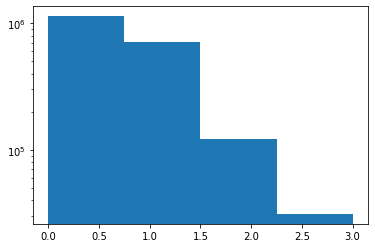

In [10]:
ratings_df = get_rating_from_listen_count(triplets_df, 1, 7, 20)
plt.hist(ratings_df['rating'], bins=4)
plt.yscale('log')
plt.show()

### Reduce dataframe due to a high memory usage

Get only songs 'rated' (listened) more than 100 times

In [11]:
song_ratings_amount = pd.read_csv('../data/1_interim/song_ratings_amount.csv', sep=",")
song_ratings_amount.head()

,Unnamed: 0,song_id,ratings_amount
0,0,SOAKIMP12A8C130995,194
1,1,SOBBMDR12A8C13253B,157
2,2,SOBXHDL12A81C204C0,1082
3,3,SOBYHAJ12A6701BF1D,557
4,4,SODACBL12A8C13C273,917


In [12]:
ratings_amount = 100
song_ratings_amount.sort_values(by=['ratings_amount'], inplace=True, ascending=False)
songs_100_ratings = song_ratings_amount[song_ratings_amount['ratings_amount'] >= ratings_amount]

In [13]:
songs_100_ratings_list = list(songs_100_ratings['song_id'])

In [14]:
triplets_ratings_df = ratings_df[(ratings_df['song_id'].isin(songs_100_ratings_list))]

In [17]:
# reduce df due to 43GiB memory allocation
reduced_triplets_df = triplets_ratings_df[:500000]

### Matrix with user_id and song_id and ratings as values

In [18]:
matrix = reduced_triplets_df.pivot_table(index='user_id', columns='song_id', values='rating')
matrix.head()

song_id,SOAACPJ12A81C21360,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAROC12A6D4FA420,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,...,SOZYUGZ12A8AE472AC,SOZZFTH12A6701E983,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F
user_id,,,,,,,,,,,,,,,,,,,,,
00003a4459f33b92906be11abe0e93efc423c0ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b474f815bcff17a4bc9ce5324f9352dafe07d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b4e4134d5f77d7608fbf86fb3e1adac4478a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating user similarity

In [19]:
user_similarity = matrix.T.corr()
user_similarity.head()

user_id,00003a4459f33b92906be11abe0e93efc423c0ff,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,000b474f815bcff17a4bc9ce5324f9352dafe07d,000b4e4134d5f77d7608fbf86fb3e1adac4478a8,000d2df2cb8ad7300f89512f8fe8fadc4f99e733,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,...,ffe5181c3f5daf9bb25a7e087d5107e4276b83e8,ffeb72b8032d5a1c2f3e1bb7c50eee19f23bcf20,ffebfec313fd515a11faba060b022f030b57fac0,ffec9b417b38e41a5f81c2cb763af9144f54885e,fff1d613baa7ce8e5acb7181093d9683804a55b6,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffad4a128cd3d130f06c0f7bf493781081afe3c,fffce9c1537fbc350ea68823d956eaa8f5236dbe
user_id,,,,,,,,,,,,,,,,,,,,,
00003a4459f33b92906be11abe0e93efc423c0ff,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b474f815bcff17a4bc9ce5324f9352dafe07d,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b4e4134d5f77d7608fbf86fb3e1adac4478a8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# User Id to make predictions
userid = '00003a4459f33b92906be11abe0e93efc423c0ff'
# Remove picked user ID from the candidate list
similar_users_matrix = user_similarity.drop(index=userid, inplace=False)
similar_users_matrix.head()

user_id,00003a4459f33b92906be11abe0e93efc423c0ff,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,000b474f815bcff17a4bc9ce5324f9352dafe07d,000b4e4134d5f77d7608fbf86fb3e1adac4478a8,000d2df2cb8ad7300f89512f8fe8fadc4f99e733,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,...,ffe5181c3f5daf9bb25a7e087d5107e4276b83e8,ffeb72b8032d5a1c2f3e1bb7c50eee19f23bcf20,ffebfec313fd515a11faba060b022f030b57fac0,ffec9b417b38e41a5f81c2cb763af9144f54885e,fff1d613baa7ce8e5acb7181093d9683804a55b6,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffad4a128cd3d130f06c0f7bf493781081afe3c,fffce9c1537fbc350ea68823d956eaa8f5236dbe
user_id,,,,,,,,,,,,,,,,,,,,,
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b474f815bcff17a4bc9ce5324f9352dafe07d,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b4e4134d5f77d7608fbf86fb3e1adac4478a8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000d2df2cb8ad7300f89512f8fe8fadc4f99e733,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = similar_users_matrix[similar_users_matrix[userid]>user_similarity_threshold][userid].sort_values(ascending=False)
# Print out top n similar users
print(f'The similar users for user {userid} are', similar_users)

The similar users for user 00003a4459f33b92906be11abe0e93efc423c0ff are user_id
5e2e280f81efab5016ba03032f2fdbc46ef6fab1    1.000000
a903813b3d755b48ace04117f1742cfd8733814d    0.870388
1a2481a1c1e47784218ca607b2fc7a2f5d00b147    0.500000
1d89006fce5d06e786942858ef2cfa24a476705a    0.500000
Name: 00003a4459f33b92906be11abe0e93efc423c0ff, dtype: float64


In [22]:
users_songs_df = pd.DataFrame(columns=triplets_df.columns.values)
for i in range(len(similar_users)):
    temp = triplets_df.loc[triplets_df['user_id'] == similar_users.index[i]]
    users_songs_df = users_songs_df.append(temp)

C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\454639768.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users_songs_df = users_songs_df.append(temp)
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\454639768.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users_songs_df = users_songs_df.append(temp)
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\454639768.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users_songs_df = users_songs_df.append(temp)
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\454639768.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users_songs_df = users_songs_df.append(temp)


In [23]:
# get unique songs
songs_to_recommend = users_songs_df.sort_values('listen_count', ascending=False)['song_id']
songs_to_recommend = songs_to_recommend.unique()
songs_to_recommend = songs_to_recommend[:10]

In [24]:
songs_to_recommend_info = pd.DataFrame(columns=song_df.columns.values)
for song in songs_to_recommend:
    songs_to_recommend_info = songs_to_recommend_info.append(song_df.loc[song_df['song_id'] == song])

C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\644284479.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  songs_to_recommend_info = songs_to_recommend_info.append(song_df.loc[song_df['song_id'] == song])
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\644284479.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  songs_to_recommend_info = songs_to_recommend_info.append(song_df.loc[song_df['song_id'] == song])
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\644284479.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  songs_to_recommend_info = songs_to_recommend_info.append(song_df.loc[song_df['song_id'] == song])
C:\Users\Ewakae\AppData\Local\Temp\ipykernel_27936\644284479.py:3: FutureWarning: The frame.append m

In [25]:
print(f'The similar users for user {userid} are', similar_users)
print(f'Songs recommended for user {userid} are:')
index = 1
for i, song_info in songs_to_recommend_info.iterrows():
    print(f"{index}. {song_info['title']} by {song_info['artist_name']}")
    index += 1

The similar users for user 00003a4459f33b92906be11abe0e93efc423c0ff are user_id
5e2e280f81efab5016ba03032f2fdbc46ef6fab1    1.000000
a903813b3d755b48ace04117f1742cfd8733814d    0.870388
1a2481a1c1e47784218ca607b2fc7a2f5d00b147    0.500000
1d89006fce5d06e786942858ef2cfa24a476705a    0.500000
Name: 00003a4459f33b92906be11abe0e93efc423c0ff, dtype: float64
Songs recommended for user 00003a4459f33b92906be11abe0e93efc423c0ff are:
1. Gravity by The Whitest Boy Alive
2. Gold Lion by Yeah Yeah Yeahs
3. Fireworks (bonus track) by The Whitest Boy Alive
4. Flume by Bon Iver
5. Not In Love by Crystal Castles
6. The Canals Of Our City by Beirut
7. You're A Wolf (Album) by Sea Wolf
8. Helicopter by Bloc Party
9. When You Were Young by The Killers
10. Wonderwall by Ryan Adams


In [ ]:
# Reset all variables
# %reset